# ARIMA: Autoregressive Integrated Moving Average

### Importing Relevant Packages

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10,7.5]

# J&J Quarterly EPS Revisited

### Import Dataset

In [3]:
data = pd.read_csv('data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


### Plotting the Data

It is clear that there is some seasonality and a positive trend.

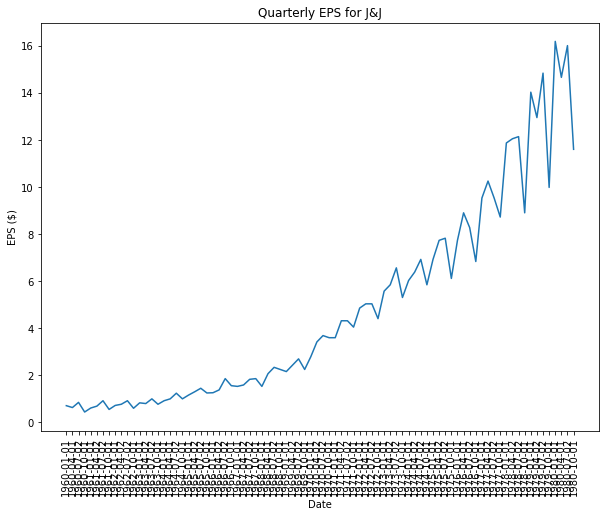

In [4]:
plt.plot(data['date'],data['data'])
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show();

### Plot ACF & PACF

ACF is indicating that the timeseries has a trend and therefore, not stationary. The PACF is indicating is going into the blue zone after lag 2. The PACF is also showing a lack of stationarity with the sinusoidal pattern. 

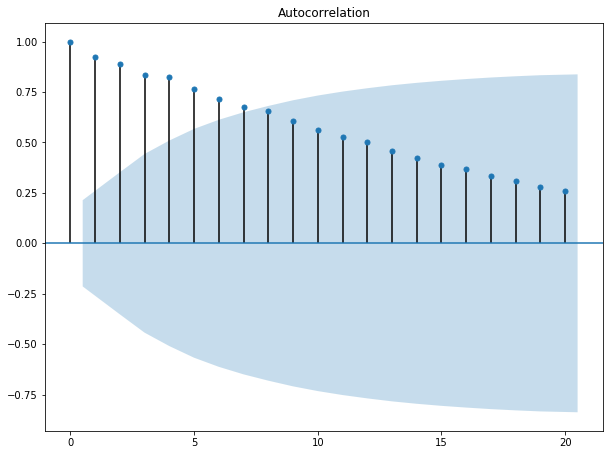

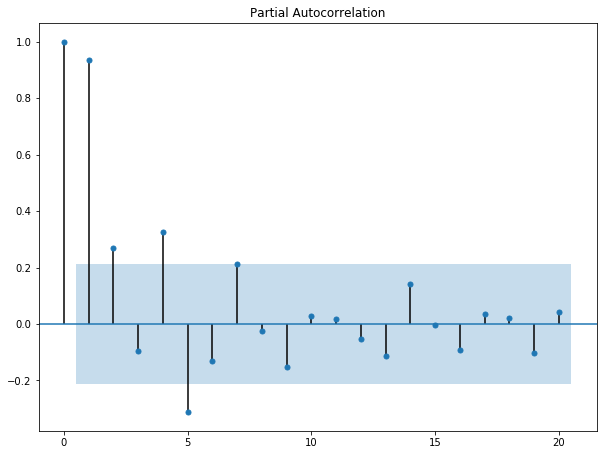

In [5]:
plot_acf(data['data']);
plot_pacf(data['data']);

### Make the Dataset Stationary

To achieve stationarity we are going to be using the log difference. Additionally, we will track the changes that we make to the dataset. 

In differencing, we lose the first element as a result of not being able to subtract the first data point from the one before it. 

In [6]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


### Plotting the Differenced Dataset

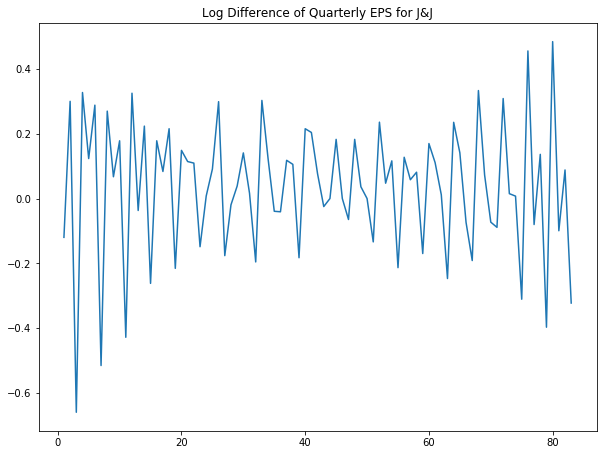

In [7]:
plt.plot(data['data_tr_1'])
plt.title('Log Difference of Quarterly EPS for J&J');

### Testing for Stationarity with AD Fuller

Yes, we can reject the null hypothesis that it is not stationary.

In [8]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811839
p-value: 0.000414973140444062


### ACF AND PACF

We add the snippet of indexing from one and onwards because the first value is NaN. One way to not have to do this would be to just drop the first value like we did in other notebooks. 

ACF is sinusoidal and decreasing. For the PACF, we can also see wavy behavior. The order cannot be concluded so we are going to write a function to test a variety of parameters. 

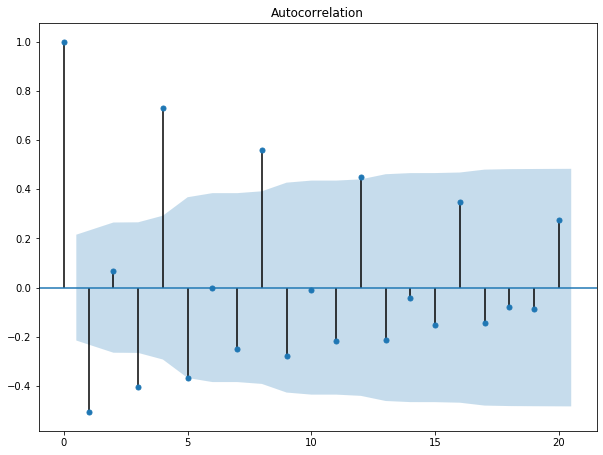

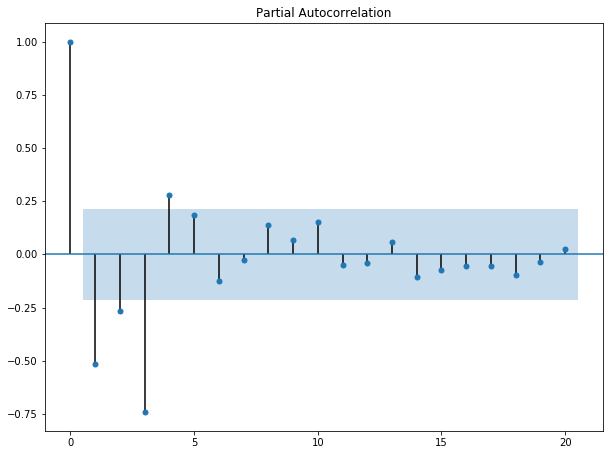

In [9]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);

### Writing a Function to Determine Order

The ACF and PACF are showing sinusoidal patterns and waves, so there is not a clear indication of the order or number of coefficients in the model equation. 
To determine the order of the equation to use on the dataset, we are going to write a function to find the best order values. 
We know that d is equal to one since we differenced the dataset one time. However, we need to determine the best p and q values. 

The tqdm_notebook allows us to see the progress of the function until completion. 

In [10]:
def optimize_ARIMA(endog, order_list):
    '''
        Returns a dataframe with parameters and corresponding AIC
        order list: list with the (p,d,q) tuples
        endog - the observed variable
    '''
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order = order, simple_differencing= False).fit(disp = False)

        except: 
            continue
        
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df
    
    

In [11]:
#Ps and Qs are ranges from zero to eight with steps of one

ps = range(0, 8, 1) 
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1,1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

### Running the Optimization

This will take a while to run. 

In [12]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.306520
1,"(4, 1, 6)",115.859272
2,"(7, 1, 1)",116.058677
3,"(5, 1, 3)",116.536687
4,"(5, 1, 4)",117.242672
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497399
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


### Best Model Params Found

The function is indicating that the best parameters are (6,1,3). Now we can pass these parameters into the model. 

The summary is showing the coefficients that would be present in the array if we were to create the arrays and run the model like we were previously reverse engineering.

In [13]:
best_model = SARIMAX(data['data'], order = (6,1,3), simple_differencing = False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.653
Date:                Mon, 23 May 2022   AIC                            115.307
Time:                        12:28:54   BIC                            139.495
Sample:                             0   HQIC                           125.024
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4682      0.120    -12.231      0.000      -1.703      -1.233
ar.L2         -0.7582      0.142     -5.352      0.000      -1.036      -0.481
ar.L3          0.0425      0.061      0.701      0.4

### Observing the Summary + Running Diagnostics

One the third row (ar.L3) the p-value is .484 and for ma.L2 the p-value is not significant as it is much higher than .05. 

For now we will keep them and take a look at the residuals. 

In the residuals we can see that it approaches a normal distribution. The Normal QQ Plot is following a mostly straight line and the correlelogram is staying within the light blue area to indicate that there is stationarity of the residuals and no missed trend/seasonality component. 

This model is considered fairly good.

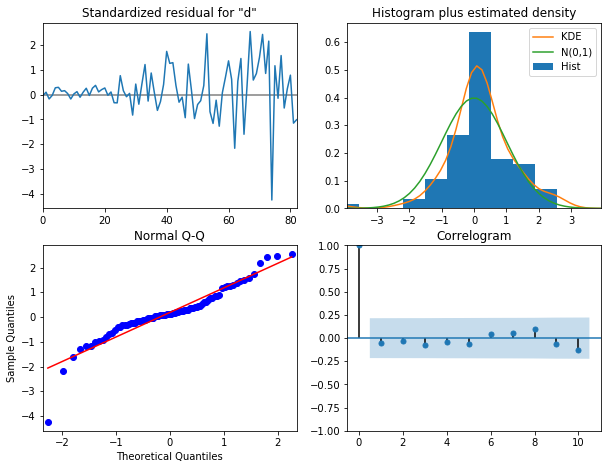

In [14]:
res.plot_diagnostics();

### Forecasting into the Future

We are working with QUARTERLY data so forecasting 8 lags into the future is actually forecasting over the next 2 years.

Here, nobs means number of observations. 



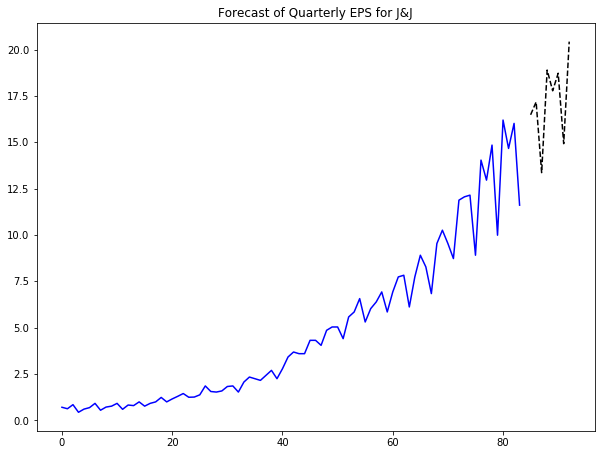

In [15]:
n_forecast = 8 
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Quarterly EPS for J&J')
plt.show();

### Evaluating the Model with MSE (Mean Squared Error)

The comparison between the modeled numbers and actual data are considered to be fairly close. 

In [16]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.680156
3,1960-10-01,0.44,-0.658462,0.721407
4,1961-01-01,0.61,0.326684,0.649749
5,1961-04-02,0.69,0.123233,0.527391
6,1961-07-02,0.92,0.287682,0.787555
7,1961-10-01,0.55,-0.514455,0.489004
8,1962-01-01,0.72,0.269333,0.650623
9,1962-04-02,0.77,0.067139,0.751072


In [18]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE: {mse}')

MSE: 0.1601743914831825


### Conclusion

This MSE is considered fairly low so the model performed well. 